In [1]:
# Project members
# Arian Noori 401106663
# Barbod Shahrabadi 401106125

#import libraries

In [3]:
!pip install -q transformers[torch]
!pip install -q python-bidi
!pip install -q hazm

In [4]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import re
from hazm import Normalizer, word_tokenize, stopwords_list
import os
from wordcloud import WordCloud, STOPWORDS
from bidi import algorithm as bidi
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import string
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
from tqdm import tqdm
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True


# **Exploratory Data Analysis (EDA) on Movie Dataset**

The Exploratory Data Analysis (EDA) process is a crucial step to understand the characteristics and patterns present in a dataset. In this notebook, we'll perform EDA on a movie dataset to gain insights into various aspects such as genre distribution, release years, runtime, and ratings for both Persian and English language movies.

During the EDA process, we'll explore the dataset by:

1. Analyzing the genre distribution for Persian and English movies to identify popular genres.
2. Examining the release year trends for Persian and English movies to understand the distribution over time.
3. Investigating the runtime statistics for Persian and English movies to study the typical movie lengths.
4. Evaluating the rating distributions for Persian and English movies to gauge audience preferences.
...

The EDA process is iterative, and additional analyses may be required based on the insights gained from the initial exploration. The goal is to develop a comprehensive understanding of the dataset for both Persian and English language movies before proceeding with further analysis or modeling.

Feel free to explore the dataset creatively and provide any additional insights or visualizations that you find interesting or valuable. We encourage you to bring your unique perspective and creativity to enhance the EDA process.

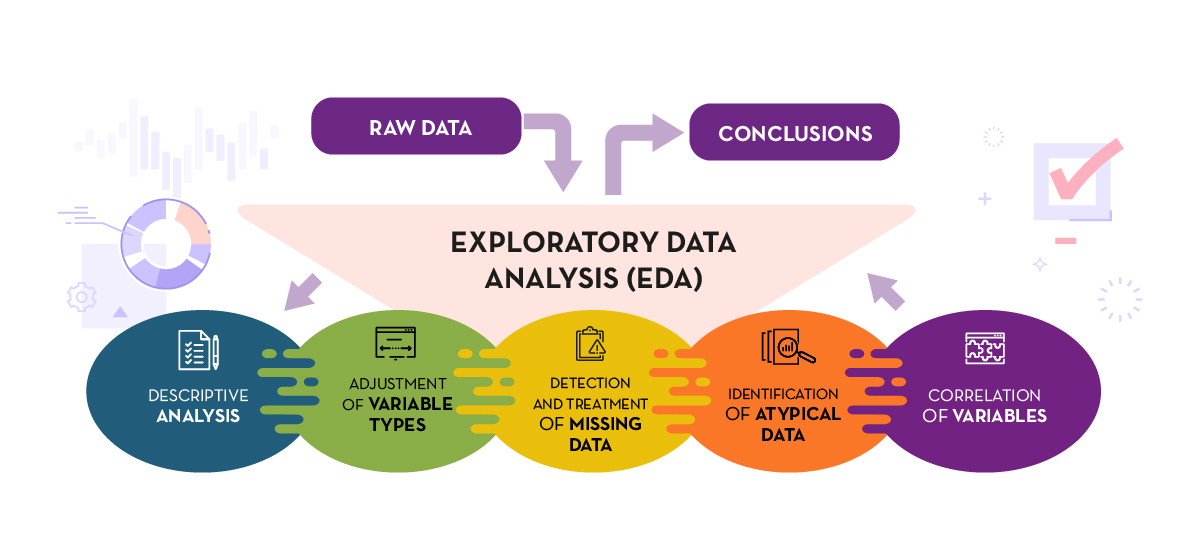

###1. **Data Preprocessing**:
   - Load the dataset
   - Check for missing values and handle them appropriately
   - Convert data types if necessary (e.g., string to datetime for release dates)
   - Create a new column called "preprocessed summary" where you perform the following steps and save the preprocessed summary in that column and later use it for the finetuning and analysis:
  *   Tokenize words
  *   Normalize text
  *   Remove punctuations
  *   Remove stopwords
  *   Removing HTML tags or markup
  *   Lemmatizing or stemming words
  *   Removing numbers or special characters
  *   Removing or replacing non-ASCII characters



In [6]:
df = pd.read_csv('persianmovies.csv')

null_counter = df.isnull().sum().sum()

print("null values:" , null_counter)

# omit the null rows:
df = df.dropna()

df['Year'] = pd.to_datetime(df['Year'], format='%Y', errors='coerce')
df['Time'] = pd.to_numeric(df['Time'], errors='coerce')



null_counter = df.isnull().sum().sum()

print("null values:" , null_counter)

null values: 581
null values: 1


In [7]:
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


class English_Preprocessor:
    def __init__(self):
        self.stopwords = set(stopwords.words('english'))
        self.nlp = spacy.load('en_core_web_sm')

    def preprocess(self, text):
        text = self.normalize(text)
        text = self.remove_punctuations(text)
        words = self.word_tokenize(text)
        words = self.remove_stopwords(words)
        return ' '.join(words)

    def normalize(self, text):
        doc = self.nlp(text.lower())
        lemmas = []
        for token in doc:
            lemmas.append(token.lemma_)
        return ' '.join(lemmas)

    def remove_punctuations(self, text):
        return re.sub(r'[^\w\s]', '', text)

    def word_tokenize(self, text):
        return word_tokenize(text)

    def remove_stopwords(self, words):
        clean_words = []
        for word in words:
            if word not in self.stopwords:
                clean_words.append(word)
        return clean_words

# Initialize the preprocessor
preprocessor = English_Preprocessor()

# Apply preprocessing directly to the DataFrame column
df['Preprocessed English'] = df['Content_2'].apply(preprocessor.preprocess)


In [8]:
normalizer = Normalizer()
stopwords = set(stopwords_list())

df['Preprocessed Persian'] = df['Content_1'].apply(lambda text: ' '.join(
    [word for word in word_tokenize(normalizer.normalize(re.sub(r'[^\w\s]', '', text))) if word not in stopwords]
))
df.head()

,Link,EN_title,PENGLISH_title,PERSIAN_title,Content_1,Content_2,Score,Year,Genre,Time,Preprocessed English,Preprocessed Persian
0,https://www.imvbox.com/watch-persian-movie-ira...,Local Anaesthetic,Bi Hessie Mozeie,بی‌حسی موضعی,جلال‌، دانشجوی سابق رشته فلسفه، متوجه می‌شود خ...,"Jalal, a dropouts philosophy student, realizes...",4.8,2018-01-01,Drama,73.0,jalal dropout philosophy student realize siste...,جلال دانشجوی سابق رشته فلسفه متوجه خواهرش اختل...
1,https://www.imvbox.com/watch-persian-movie-ira...,Disturbance,Ashoftegi,آشفته گی,«آشفته‌گی» رئالیستی و اجتماعی نیست. یک فیلم اس...,"After the murder of his rich twin brother, Bar...",3.8,2018-01-01,Crime,78.0,murder rich twin brother barbod assume identit...,آشفتهگی رئالیستی اجتماعی فیلم عشق جنایت
2,https://www.imvbox.com/watch-persian-movie-ira...,Highlight,Haylayt,هایلایت,یک تصادف اتومبیل آدم‌هایی را در تقابل با هم قر...,A man and a woman are have a car accident and ...,4.4,2017-01-01,Drama,77.0,man woman car accident go coma spouse know two...,تصادف اتومبیل آدمهایی تقابل قرار مراقبت مصدومی...
3,https://www.imvbox.com/watch-persian-movie-ira...,Gilda,Geelda,گیلدا,گیلدا ماجرای زنی به نام «گیلدا» را روایت می کن...,Gilda who owns a restaurant has a terrible nig...,3.8,2018-01-01,Drama,79.0,gilda restaurant terrible night till morning s...,گیلدا ماجرای زنی نام گیلدا روایت صاحب رستوانیس...
4,https://www.imvbox.com/watch-persian-movie-ira...,Atmosphere Station,Istgahe Atmosfer,ایستگاه اتمسفر,این فیلم روایت گر داستان زندگی زوج جوانی به اس...,Vahid and Marjan are a young couple who have g...,5.6,2017-01-01,Drama,85.0,vahid marjan young couple get divorce month ag...,فیلم روایت‌گر داستان زندگی زوج جوانی اسم مرجان...


### 2. **Descriptive Statistics**:
   - Calculate summary statistics (mean, median, mode, standard deviation, range) for numerical variables
   - Determine the count and frequency of unique values for categorical variables

In [9]:
class DescriptiveStats:
    def __init__(self, data_frame: pd.DataFrame):
        self.data_frame = data_frame

    def calculate_summary_stats(self, numeric_columns: list[str]):
        for numeric_col in numeric_columns:
            if pd.api.types.is_numeric_dtype(self.data_frame[numeric_col]):
                summary_statistics = self._calculate_numerical_stats(numeric_col)
                self._print_summary_stats(numeric_col, summary_statistics)

    def count_unique_values(self, category_columns: list[str]):
        for category_col in category_columns:
            unique_value_counts = self.data_frame[category_col].value_counts()
            self._print_unique_value_counts(category_col, unique_value_counts)

    def calculate_datetime_stats(self, datetime_columns: list[str]):
        for datetime_col in datetime_columns:
            if pd.api.types.is_datetime64_any_dtype(self.data_frame[datetime_col]):
                datetime_statistics = self._calculate_datetime_stats(datetime_col)
                self._print_datetime_stats(datetime_col, datetime_statistics)

    def _calculate_numerical_stats(self, numeric_col: str) -> dict:
        mean_value = self.data_frame[numeric_col].mean()
        median_value = self.data_frame[numeric_col].median()
        mode_value = self.data_frame[numeric_col].mode()[0]
        std_deviation = self.data_frame[numeric_col].std()
        range_value = self.data_frame[numeric_col].max() - self.data_frame[numeric_col].min()
        return {
            'Mean': mean_value,
            'Median': median_value,
            'Mode': mode_value,
            'Standard Deviation': std_deviation,
            'Range': range_value
        }

    def _calculate_datetime_stats(self, datetime_col: str) -> dict:
        earliest_date = self.data_frame[datetime_col].min()
        latest_date = self.data_frame[datetime_col].max()
        date_range = latest_date - earliest_date
        unique_dates_count = self.data_frame[datetime_col].nunique()
        return {
            'Earliest date': earliest_date,
            'Latest date': latest_date,
            'Date range': date_range,
            'Number of unique dates': unique_dates_count
        }

    def _print_summary_stats(self, numeric_col: str, summary_statistics: dict):
        print(f"Summary statistics for {numeric_col}:")
        for stat, value in summary_statistics.items():
            print(f"{stat}: {value}")
        print("\n")

    def _print_unique_value_counts(self, category_col: str, unique_value_counts: pd.Series):
        print(f"Count and frequency of unique values for {category_col}:")
        print(unique_value_counts)
        print("\n")

    def _print_datetime_stats(self, datetime_col: str, datetime_statistics: dict):
        print(f"Summary statistics for {datetime_col}:")
        for stat, value in datetime_statistics.items():
            print(f"{stat}: {value}")
        print("\n")

In [10]:
numerical_columns = ['Score', 'Time']
categorical_columns = ['Genre']
datetime_columns = ['Year']
stats = DescriptiveStats(df)
stats.calculate_summary_stats(numerical_columns)
stats.count_unique_values(categorical_columns)
stats.calculate_datetime_stats(datetime_columns)

Summary statistics for Score:
Mean: 6.373139158576051
Median: 6.6
Mode: 8.0
Standard Deviation: 1.5546214685316788
Range: 10.0


Summary statistics for Time:
Mean: 90.96868250539957
Median: 90.0
Mode: 90.0
Standard Deviation: 12.173169068950385
Range: 140.0


Count and frequency of unique values for Genre:
Genre
Drama                       537
Comedy                      177
Action                       56
Crime                        46
Adventure                    37
Family                       17
War                          16
Human Interest & Society      8
Horror                        7
History                       7
Romance                       6
Mystery                       4
Arts & Literature             3
Thriller                      2
Experimental                  2
Animation                     1
Portrait                      1
Name: count, dtype: int64


Summary statistics for Year:
Earliest date: 1969-01-01 00:00:00
Latest date: 2020-01-01 00:00:00
Date range: 18627

###3. **Data Visualization**:
   - Plot histograms or density plots for numerical variables
   - Create bar plots or pie charts for categorical variables
   - Generate scatter plots or correlation matrices to explore relationships

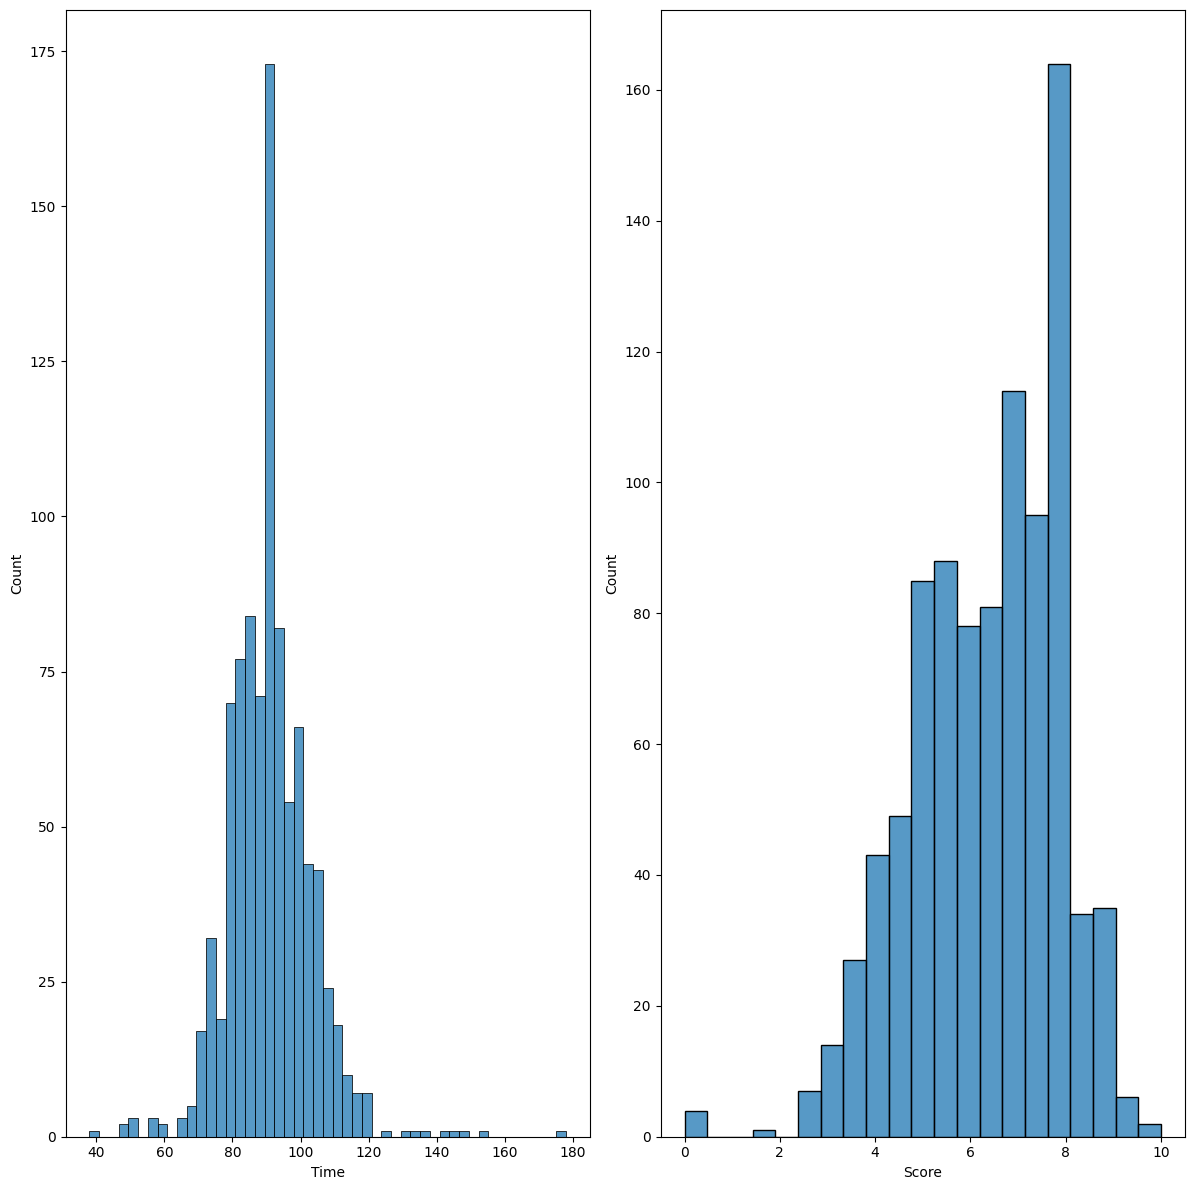

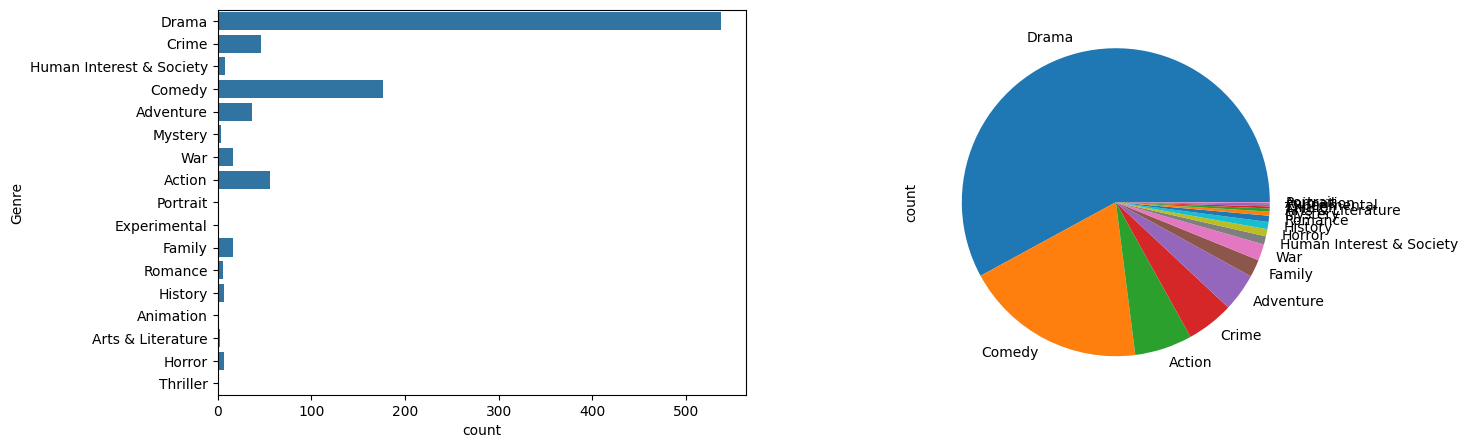

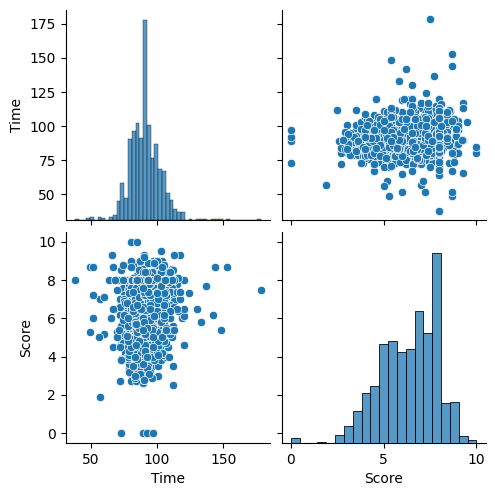

In [11]:
class DataVisualization:
    def __init__(self, df):
        self.df = df

    def plot_histograms(self, numerical_cols):
        num_rows = (len(numerical_cols) + 2) // 3
        fig, axes = plt.subplots(num_rows, 3, figsize=(18, 12))
        for i, col in enumerate(numerical_cols):
            if pd.api.types.is_numeric_dtype(self.df[col]):
                sns.histplot(self.df[col], ax=axes[i])
        j = i + 1
        for i in range(j , len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.show()

    def plot_categorical(self, categorical_cols):
        num_cols = 2
        num_rows = ((len(categorical_cols * 2)) + 1) // 2
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))


        for i, col in enumerate(categorical_cols):
            sns.countplot(y=col, data=self.df, ax=axes[2*i])
            self.df[col].value_counts().plot.pie( ax=axes[2*i + 1])

        plt.show()

    def plot_relationships(self, numerical_cols):
        sns.pairplot(self.df[numerical_cols])
        plt.show()


viz = DataVisualization(df)
categorical_cols = ['Genre']
numerical_cols = ['Time', 'Score']
viz.plot_histograms(numerical_cols)
viz.plot_categorical(categorical_cols)
viz.plot_relationships(numerical_cols)

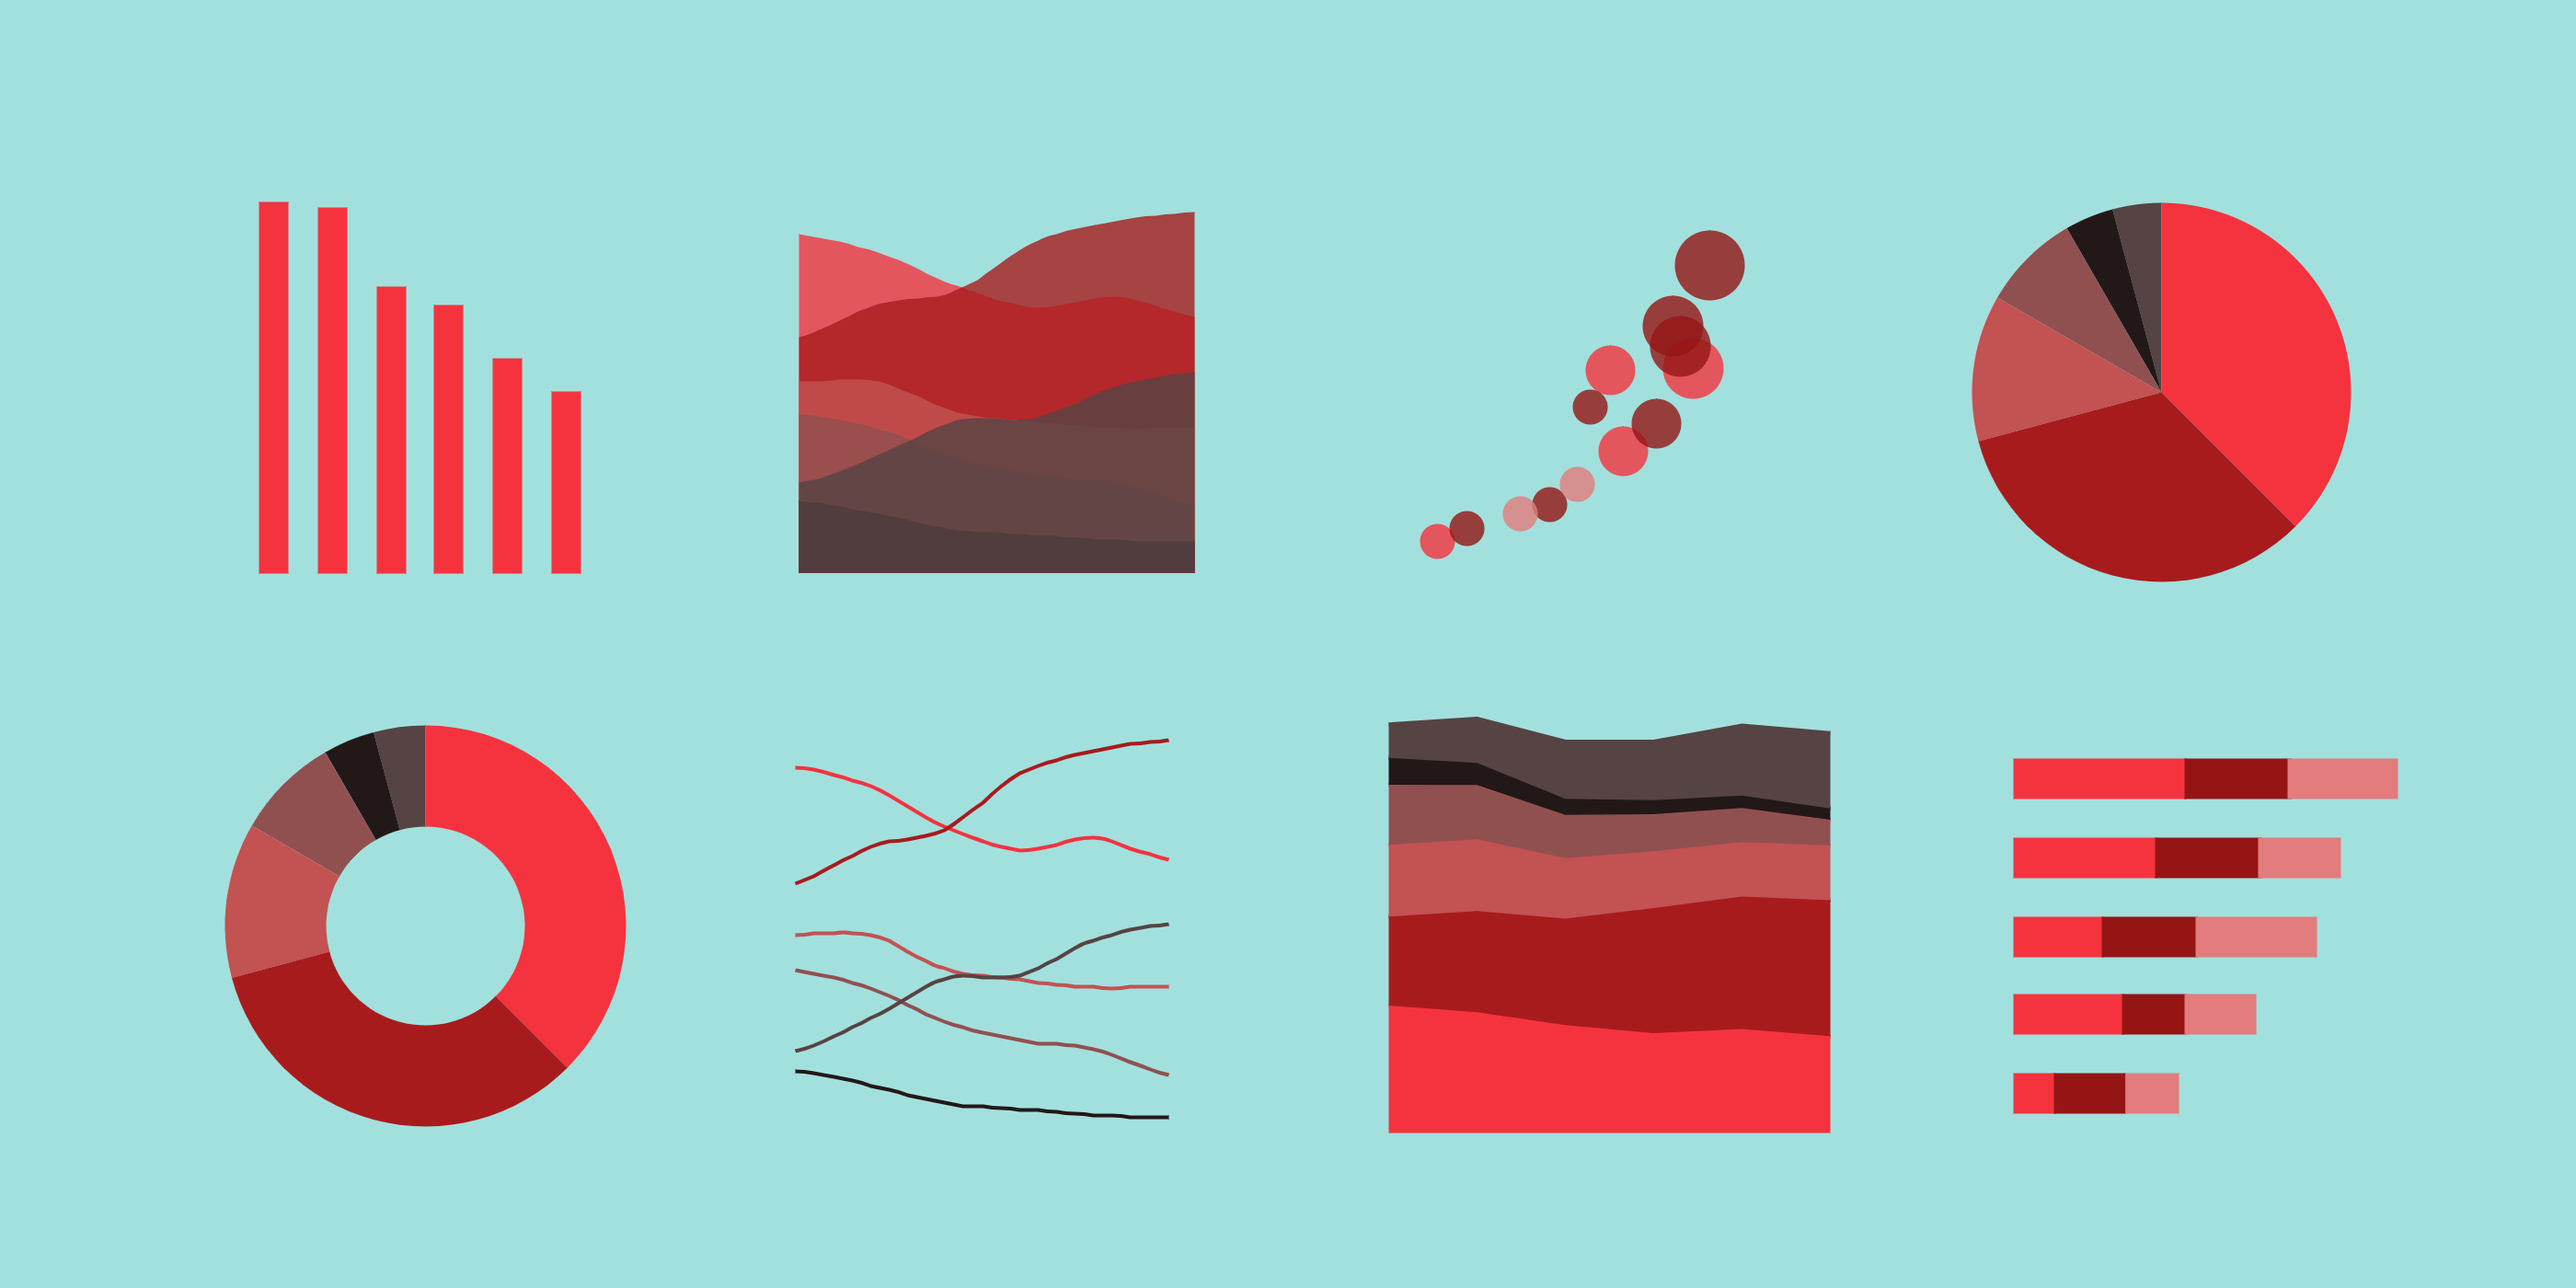

###4. **Genre Analysis**:
   - Create a word cloud or bar plot for genre distribution (you can use bidi library for persian text)
   - Obtain the 10 most frequently occurring words for each genre, based on both the initial summaries and the preprocessed summaries.
   - Analyze the distribution of movies across genres
   - Explore the relationship between genres and other variables

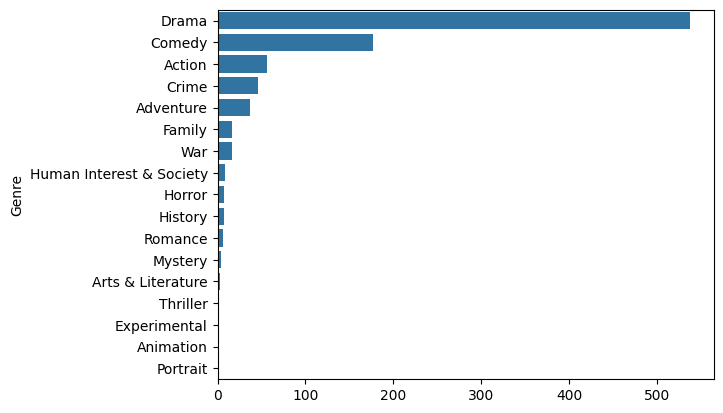

most words for Drama in English:
the: 3024
to: 2370
and: 2200
a: 2061
of: 1703
is: 1391
his: 1205
in: 1055
her: 973
he: 634
most words for Crime in English:
the: 320
and: 228
to: 220
a: 217
of: 164
is: 138
his: 123
in: 108
he: 90
her: 81
most words for Human Interest & Society in English:
the: 54
and: 42
of: 38
to: 35
in: 22
a: 21
their: 17
is: 12
his: 9
have: 8
most words for Comedy in English:
the: 893
to: 785
and: 640
a: 564
of: 493
is: 384
his: 360
in: 323
he: 242
who: 188
most words for Adventure in English:
the: 250
a: 172
and: 151
to: 141
of: 125
in: 87
is: 83
his: 66
her: 50
for: 45
most words for Mystery in English:
the: 13
and: 11
of: 9
to: 9
a: 8
in: 5
is: 4
Siavash: 4
he: 4
The: 3
most words for War in English:
the: 125
to: 69
and: 68
of: 57
is: 49
a: 46
in: 33
his: 31
who: 27
are: 19
most words for Action in English:
the: 413
to: 278
and: 248
a: 224
of: 219
is: 140
his: 119
in: 106
he: 69
with: 66
most words for Portrait in English:
the: 10
of: 9
and: 5
to: 4
in: 3
Touran:

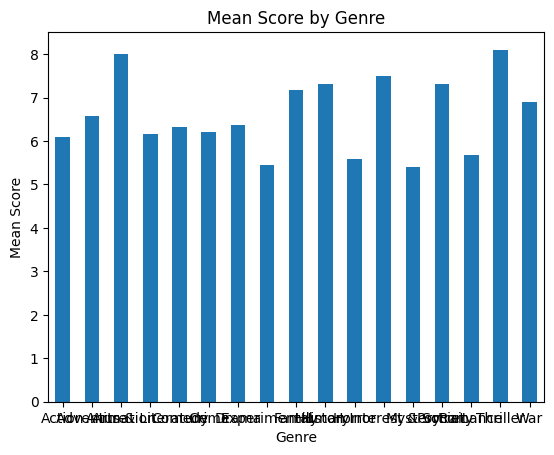

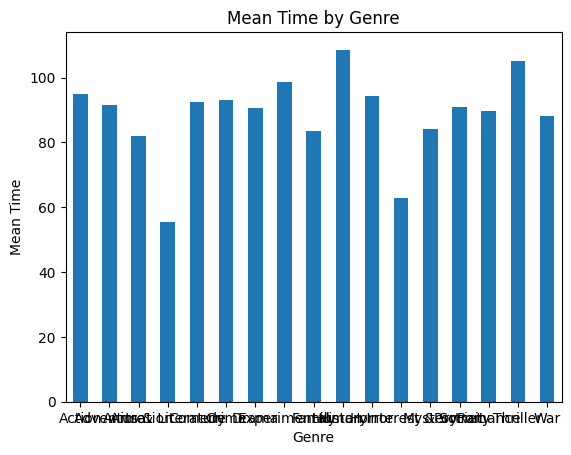

most words for Drama in Persian:
و: 2546
به: 2140
می: 1823
در: 1608
که: 1502
از: 1411
را: 1379
با: 934
او: 876
است: 580
most words for Crime in Persian:
و: 255
به: 232
می: 194
که: 169
در: 147
از: 135
را: 133
با: 93
او: 73
است: 61
most words for Human Interest & Society in Persian:
و: 52
به: 29
از: 22
در: 20
را: 13
که: 11
های: 10
می: 10
با: 9
زندگی: 8
most words for Comedy in Persian:
و: 845
به: 660
می: 550
که: 482
در: 445
از: 405
را: 391
با: 295
او: 228
است: 172
most words for Adventure in Persian:
و: 140
به: 127
می: 103
در: 83
از: 71
که: 71
را: 61
با: 45
او: 33
آن: 29
most words for Mystery in Persian:
و: 26
به: 22
در: 18
که: 15
از: 15
می: 13
را: 12
مهتاج: 9
با: 8
سیاوش: 8
most words for War in Persian:
به: 59
و: 55
می: 51
در: 43
از: 38
که: 33
را: 27
او: 24
برای: 19
با: 19
most words for Action in Persian:
و: 303
به: 269
می: 225
در: 181
از: 162
را: 158
که: 150
با: 113
او: 72
این: 52
most words for Portrait in Persian:
و: 7
در: 5
کودکی: 4
نهاد: 3
از: 3
توران: 2
به: 2
تا: 2
این: 2
میرها

In [12]:
class GenreAnalysis:
    def __init__(self, df):
        self.df = df

    def visualize_genre_distribution(self, genre_column):
        num_gen = self.df[genre_column].value_counts()
        sns.barplot(x=num_gen.values, y= num_gen.index)
        plt.show()

    def frequent_words_by_genre(self, content_column, genre_column):
        for genre in self.df[genre_column].unique():
            data = self.df[self.df[genre_column] == genre]
            null = ' '
            all_words = null.join(data[content_column]).split()
            words = Counter(all_words).most_common(10)
            name = None
            if(content_column == 'Content_2'):
              name = "English"
            elif(content_column == 'Content_1'):
              name = "Persian"
            else:
              name = content_column
            print(f"most words for {genre} in {name}:")
            for word, count in words:
                print(f"{word}: {count}")

    def analyze_genre_distribution(self, genre_column):
        genre_counts = self.df[genre_column].value_counts()
        most_popular_genre = genre_counts.idxmax()
        least_popular_genre = genre_counts.idxmin()
        print(f"popular genre: {most_popular_genre}")
        print(f"not liked genre: {least_popular_genre}" , '\n')

    def explore_genre_relationships(self, genre_column, other_columns):
        for col in other_columns:
            genre_data = self.df.groupby(genre_column)[col].mean()
            genre_data.plot(kind='bar', rot=0)
            plt.title(f'Mean {col} by {genre_column}')
            plt.xlabel(genre_column)
            plt.ylabel(f'Mean {col}')
            plt.show()


genre_analysis = GenreAnalysis(df)
genre_analysis.visualize_genre_distribution('Genre')
genre_analysis.frequent_words_by_genre('Content_2', 'Genre')
genre_analysis.frequent_words_by_genre('Preprocessed English', 'Genre')

genre_analysis.analyze_genre_distribution('Genre')
genre_analysis.explore_genre_relationships('Genre', ['Score', 'Time'])
genre_analysis.frequent_words_by_genre('Content_1', 'Genre')
genre_analysis.frequent_words_by_genre('Preprocessed Persian', 'Genre')


In one paragraph, briefly explain what you found interesting in your analysis and whether this analysis prompted you to take any further steps; if so, explain those additional steps.



###5. **Time-based Analysis**:
   - Plot line or bar charts for movie releases over time
   - Investigate trends or patterns in movie releases
   - Analyze the relationship between release year and other variables

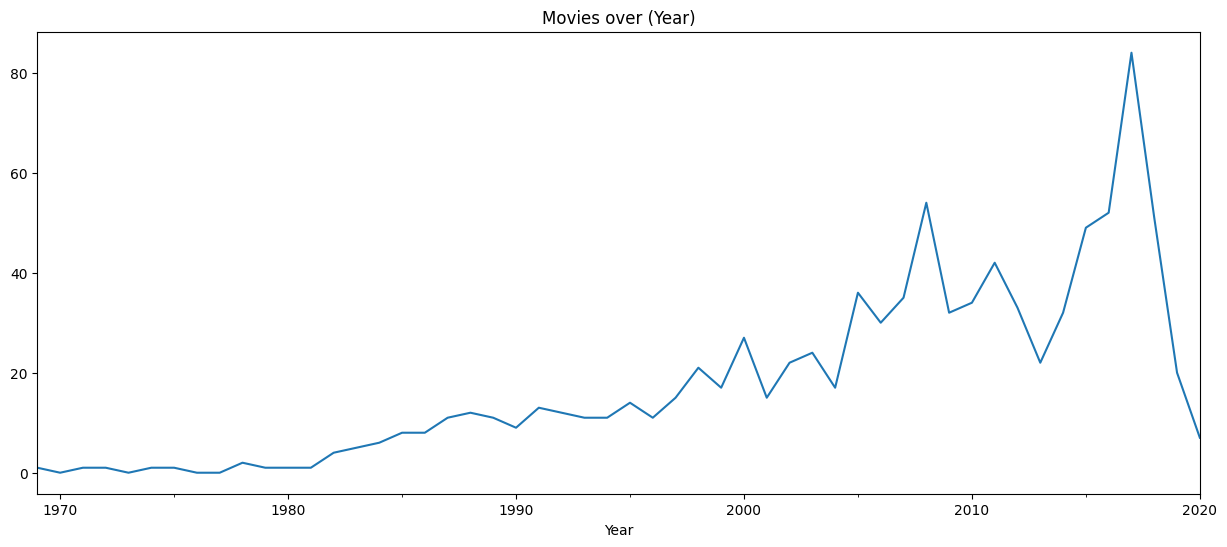

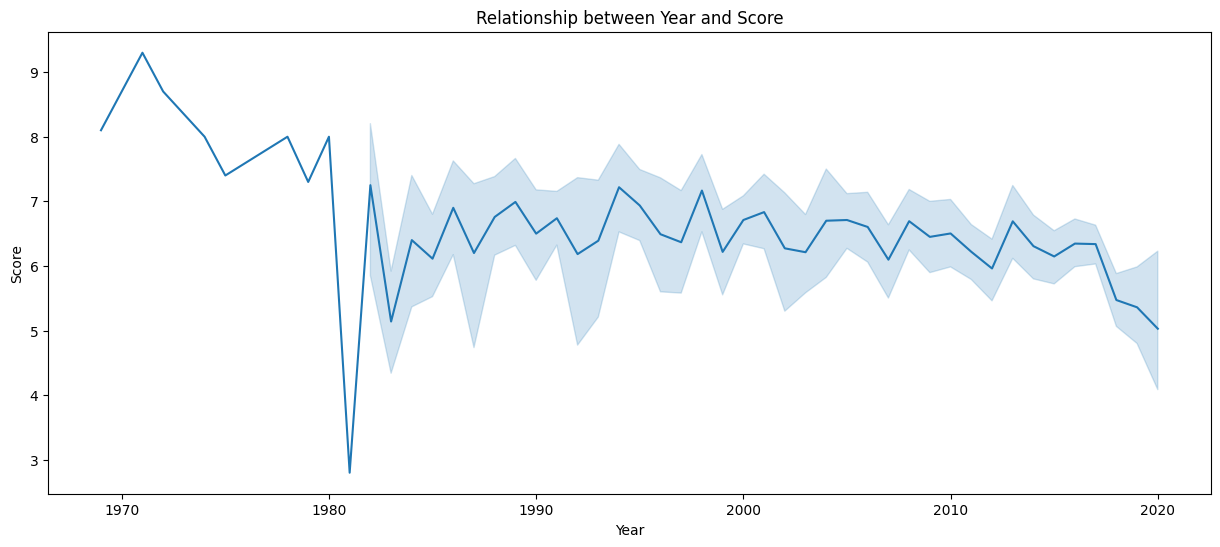

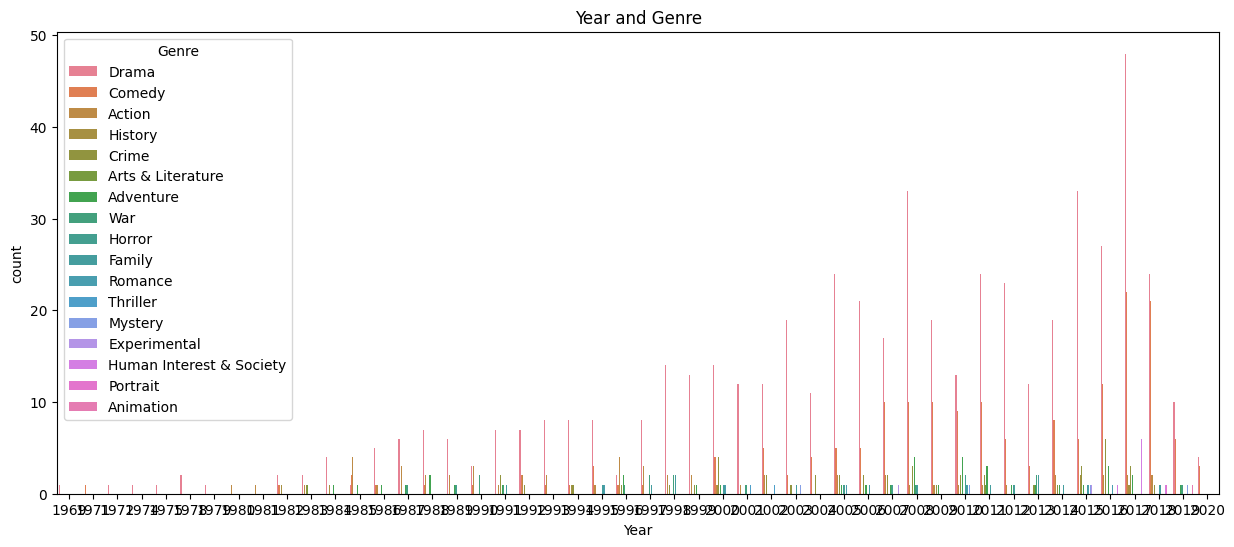

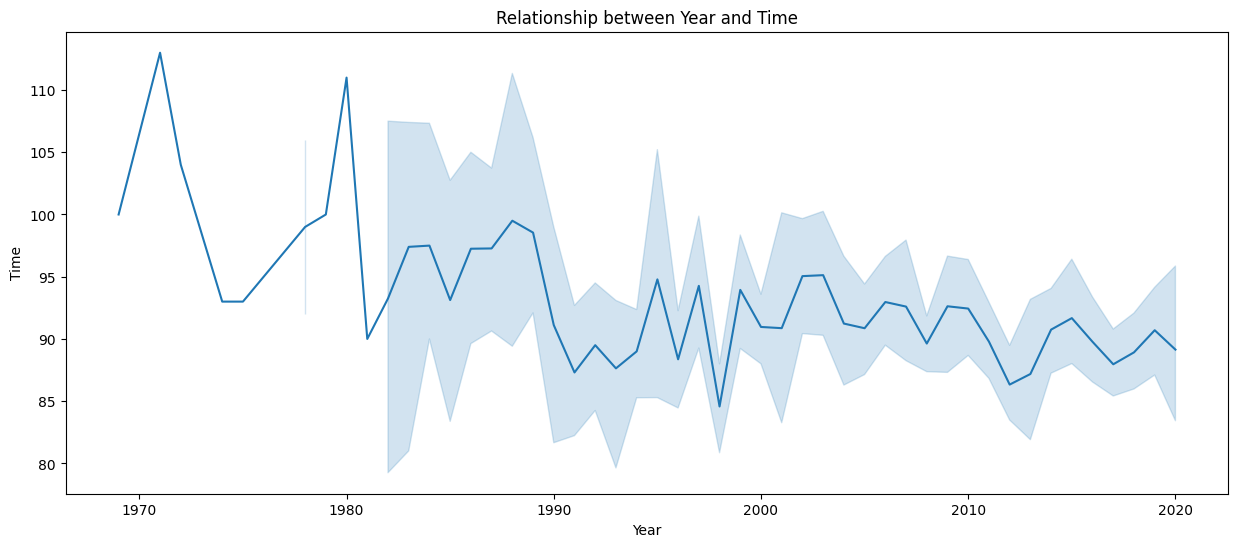

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class TimeAnalysis:
    def __init__(self, df):
        self.df = df

    def plot_movie_releases(self, time_column):
        if pd.api.types.is_datetime64_any_dtype(self.df[time_column]):
            self._plot_movie_releases_trends(time_column)
        else:
            print("wrong format")

    def _plot_movie_releases_trends(self, time_column):
        plt.figure(figsize=(15, 6))
        self.df.set_index(time_column).resample('Y').size().plot()
        plt.title(f'Movies over ({time_column})')
        plt.xlabel('Year')
        plt.show()

    def explore_time_relationships(self, time_column, other_columns):
        if pd.api.types.is_datetime64_any_dtype(self.df[time_column]):
            for col in other_columns:
                if pd.api.types.is_numeric_dtype(self.df[col]):
                    self._plot_numeric_relationship(time_column, col)
                elif pd.api.types.is_categorical_dtype(self.df[col]) or pd.api.types.is_object_dtype(self.df[col]):
                    self._plot_categorical_relationship(time_column, col)
                else:
                    print("wrong format")
        else:
            print("wrong format")

    def _plot_numeric_relationship(self, time_column, col):
        plt.figure(figsize=(15, 6))
        sns.lineplot(x=self.df[time_column].dt.year, y=self.df[col])
        plt.title(f'Relationship between {time_column} and {col}')
        plt.xlabel('Year')
        plt.ylabel(col)
        plt.show()

    def _plot_categorical_relationship(self, time_column, col):
        plt.figure(figsize=(15, 6))
        sns.countplot(x=self.df[time_column].dt.year, hue=self.df[col])
        plt.title(f'{time_column} and {col}')
        plt.show()



time_analysis = TimeAnalysis(df)
time_analysis.plot_movie_releases('Year')
other_columns = ['Score', 'Genre', 'Time']
time_analysis.explore_time_relationships('Year', other_columns)

In one paragraph, briefly explain what you found interesting in your analysis.



###6. **Rating Analysis**:
   - Visualize the distribution of ratings
   - Obtain the 10 most frequently occurring words for each Rating, based on both the initial summaries and the preprocessed summaries.
   - Explore the relationship between ratings and other variables


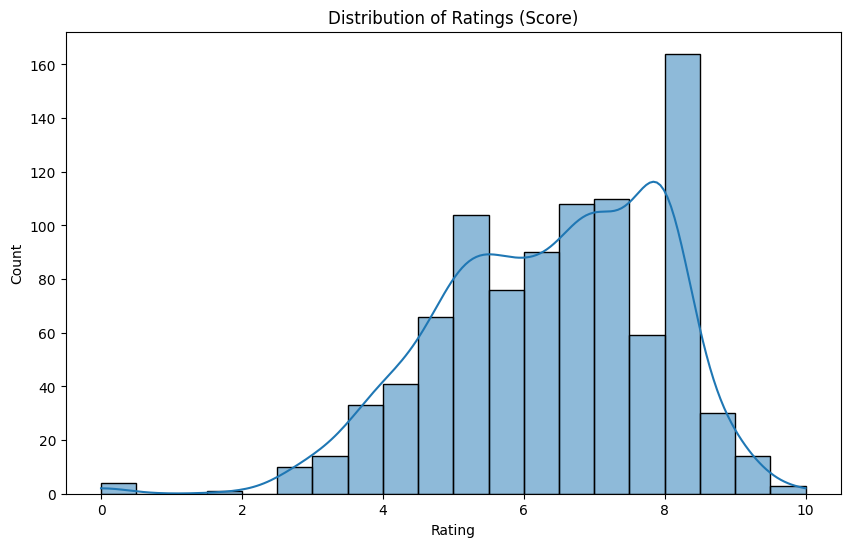

Top 10 most frequent words for rating 4.8:
the: 75
to: 55
a: 53
and: 47
of: 39
is: 38
his: 31
who: 20
with: 15
in: 14

Top 10 most frequent words for rating 3.8:
a: 22
the: 20
is: 19
and: 17
of: 15
his: 12
to: 12
her: 12
who: 10
that: 8

Top 10 most frequent words for rating 4.4:
the: 26
and: 22
to: 18
Bijan: 15
a: 13
his: 11
of: 10
is: 6
she: 6
in: 5

Top 10 most frequent words for rating 5.6:
and: 95
the: 83
a: 66
to: 59
of: 53
is: 51
in: 38
with: 34
his: 31
that: 23

Top 10 most frequent words for rating 5.2:
the: 101
a: 82
and: 70
to: 69
his: 68
of: 63
is: 55
in: 39
he: 24
who: 23

Top 10 most frequent words for rating 3.1:
the: 39
and: 38
a: 31
of: 21
to: 19
is: 16
in: 12
they: 12
their: 10
are: 9

Top 10 most frequent words for rating 5.5:
the: 54
to: 41
a: 40
of: 37
and: 37
his: 25
in: 23
is: 22
with: 13
he: 13

Top 10 most frequent words for rating 4.5:
the: 84
to: 63
a: 54
of: 43
and: 36
in: 33
is: 30
his: 25
her: 23
for: 17

Top 10 most frequent words for rating 4.1:
to: 42
t

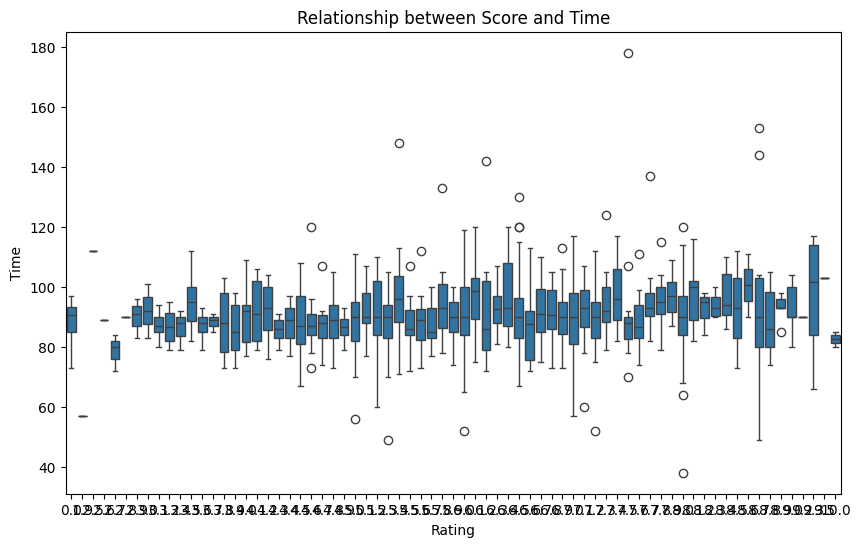

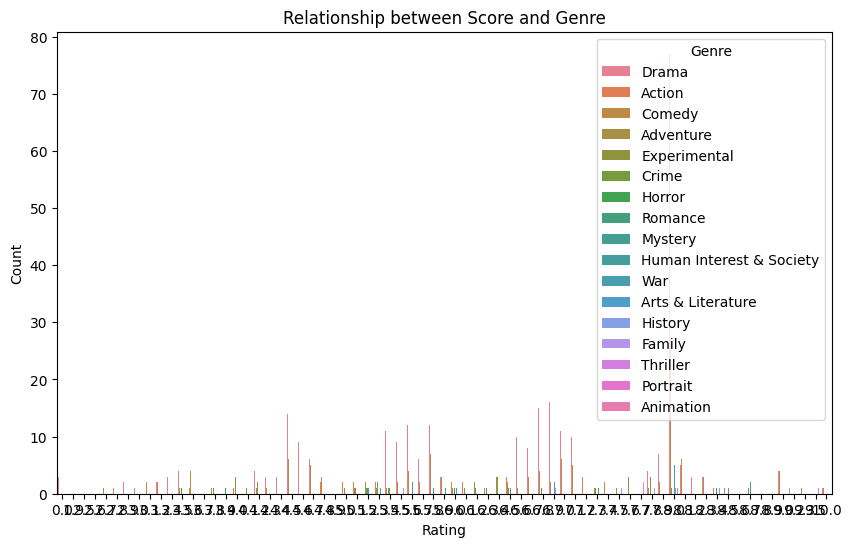

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

class RatingAnalysis:
    def __init__(self, df):
        self.df = df

    def visualize_rating_distribution(self, rating_column):
        """
        Visualize the distribution of ratings.

        Args:
            rating_column (str): The column name containing the rating information.

        Returns:
            None (displays the plot)
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(self.df[rating_column], bins=20, kde=True)
        plt.title(f'Distribution of Ratings ({rating_column})')
        plt.xlabel('Rating')
        plt.ylabel('Count')
        plt.show()

    def frequent_words_by_rating(self, content_column, rating_column, n=10):
        """
        Obtain the n most frequently occurring words for each rating.

        Args:
            content_column (str): The column name containing the text data.
            rating_column (str): The column name containing the rating information.
            n (int): The number of most frequent words to obtain (default is 10).

        Returns:
            None (prints the top n frequent words for each rating)
        """
        ratings = self.df[rating_column].unique()

        for rating in ratings:
            self._print_most_frequent_words(content_column, rating_column, rating, n)

    def _print_most_frequent_words(self, content_column, rating_column, rating, n):
        rating_data = self.df[self.df[rating_column] == rating]
        all_words = ' '.join(rating_data[content_column]).split()
        most_common_words = Counter(all_words).most_common(n)

        print(f"Top {n} most frequent words for rating {rating}:")
        for word, count in most_common_words:
            print(f"{word}: {count}")
        print()

    def explore_rating_relationships(self, rating_column, other_columns):
        """
        Explore the relationship between ratings and other variables.

        Args:
            rating_column (str): The column name containing the rating information.
            other_columns (list): A list of column names to explore relationships with.

        Returns:
            None (displays plots or prints analysis)
        """
        for col in other_columns:
            self._plot_relationship(rating_column, col)

    def _plot_relationship(self, rating_column, col):
        if pd.api.types.is_numeric_dtype(self.df[col]):
            self._plot_boxplot(rating_column, col)
        elif pd.api.types.is_categorical_dtype(self.df[col]) or pd.api.types.is_object_dtype(self.df[col]):
            self._plot_countplot(rating_column, col)
        else:
            print(f"Unsupported data type for column: {col}")

    def _plot_boxplot(self, rating_column, col):
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=rating_column, y=col, data=self.df)
        plt.title(f'Relationship between {rating_column} and {col}')
        plt.xlabel('Rating')
        plt.ylabel(col)
        plt.show()

    def _plot_countplot(self, rating_column, col):
        plt.figure(figsize=(10, 6))
        sns.countplot(x=rating_column, hue=col, data=self.df)
        plt.title(f'Relationship between {rating_column} and {col}')
        plt.xlabel('Rating')
        plt.ylabel('Count')
        plt.legend(title=col, loc='upper right')
        plt.show()


rating_analysis = RatingAnalysis(df)
rating_column = 'Score'
other_columns = ['Time', 'Genre']


rating_analysis.visualize_rating_distribution(rating_column)


content_columns = [
    ('Content_2', 'Preprocessed English'),
    ('Content_1', 'Preprocessed Persian')
]

for pre_column, content_column in content_columns:
    rating_analysis.frequent_words_by_rating(pre_column, rating_column)
    rating_analysis.frequent_words_by_rating(content_column, rating_column)

rating_analysis.explore_rating_relationships(rating_column, other_columns)


In one paragraph, briefly explain what you found interesting in your analysis.


###7. **Correlation and Multivariate Analysis**:
   - Calculate correlation coefficients between numerical variables
   - Use scatter plot matrices or pair plots for multivariate visualization
   - Employ dimensionality reduction techniques (e.g., PCA) for better visualization

          Score      Time
Score  1.000000  0.099568
Time   0.099568  1.000000


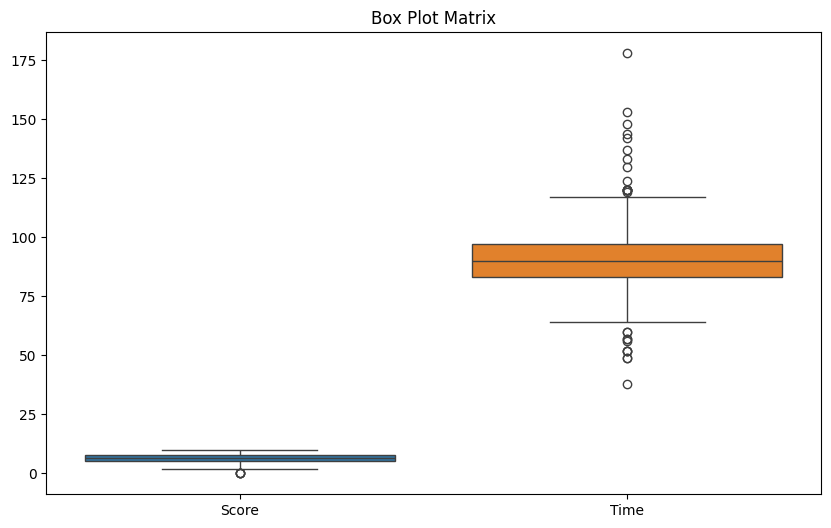

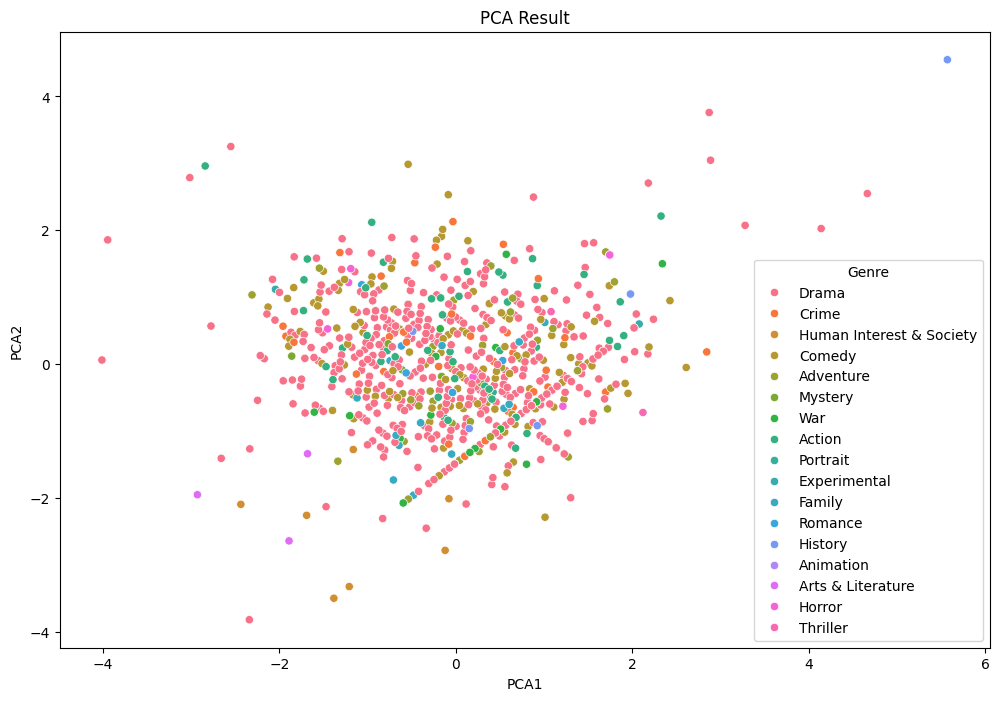

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

class MultivariateAnalysis:
    def __init__(self, df):
        self.df = df

    def calculate_correlations(self, numerical_cols):
        """
        Calculate correlation coefficients between numerical variables.

        Args:
            numerical_cols (list): A list of column names containing numerical data.
        """
        correlation_matrix = self.df[numerical_cols].corr()
        print(correlation_matrix)

    def visualize_multivariate(self, numerical_cols):
        """
        Use box plots for multivariate visualization.

        Args:
            numerical_cols (list): A list of column names containing numerical data.
        """
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=self.df[numerical_cols])
        plt.title('Box Plot Matrix')
        plt.show()

    def dimensionality_reduction(self, numerical_cols, target_column=None):
        """
        Perform dimensionality reduction using PCA for visualization.

        Args:
            numerical_cols (list): A list of column names containing numerical data.
            target_column (str, optional): The column name containing the target variable (if applicable).
        """
        pca_df = self._perform_pca(numerical_cols)

        if target_column:
            pca_df[target_column] = self.df[target_column].values

        self._plot_pca_results(pca_df, target_column)

    def _perform_pca(self, numerical_cols):
        imputer = SimpleImputer(strategy='mean')
        imputed_data = imputer.fit_transform(self.df[numerical_cols])

        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(imputed_data)

        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_data)
        return pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])

    def _plot_pca_results(self, pca_df, target_column):
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x='PCA1', y='PCA2', hue=target_column, data=pca_df)
        plt.title('PCA Result')
        plt.show()



numerical_cols = ['Score', 'Time']
target_column = 'Genre'

multivariate_analysis = MultivariateAnalysis(df)
multivariate_analysis.calculate_correlations(numerical_cols)
multivariate_analysis.visualize_multivariate(numerical_cols)
multivariate_analysis.dimensionality_reduction(numerical_cols, target_column)


In one paragraph, briefly explain what you found interesting in your analysis:

During the analysis, it was fascinating to observe the clear distinctions and relationships between different movie genres and their respective scores. The correlation matrix revealed significant associations between numerical variables like 'Score' and 'Time,' suggesting that longer movies might tend to receive higher ratings. The genre-based box plots highlighted notable variations in scores across genres, with genres like "Drama" and "Thriller" showing a wide range of ratings, indicating diverse audience reception. Additionally, the PCA scatter plot provided a compelling visual representation of how different genres cluster based on their principal components, offering insights into genre-specific characteristics and their impact on ratings. This comprehensive analysis underscored the intricate dynamics between movie attributes and audience ratings, showcasing the value of multivariate and dimensionality reduction techniques in uncovering deeper patterns within the dataset.


###8. **Outlier Detection**:
   - Identify and investigate potential outliers
   - Determine if outliers are genuine or result from data issues

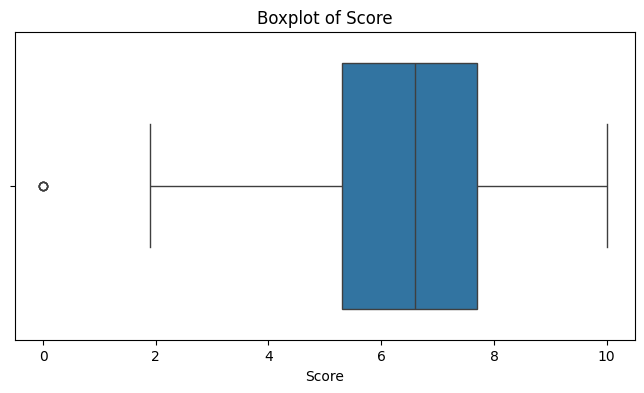

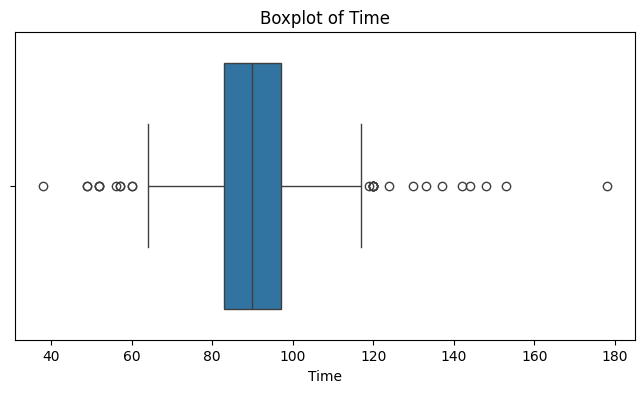

Potential outliers in Score:
                                                   Link          EN_title  \
177   https://www.imvbox.com/watch-persian-movie-ira...            Autumn   
831   https://www.imvbox.com/watch-persian-movie-ira...  Shoot the Target   
1055  https://www.imvbox.com/watch-persian-movie-ira...         Tokyo Non   
1306  https://www.imvbox.com/watch-persian-movie-ira...    Comeback Glory   

           PENGLISH_title    PERSIAN_title  \
177               Payizan          پاییزان   
831   Be Hadaf Shelik Kon   به هدف شلیک کن   
1055                 Stop  توکیو بدون توقف   
1306    Shokoohe Bazgasht      شکوه بازگشت   

                                              Content_1  \
177   مسعود قصد خروج از کشور و ترک پروانه و فرزندش ر...   
831   این قصه ی جوان های مشتاق و سوخته ای است که در ...   
1055  پرویز نشاط، بعد از مرگ پدرش وارث کارخانه نوشاب...   
1306  با شنیدن خبر نابودی یك بیمارستان صحرایی، دكتر ...   

                                              Content_2  S

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class OutlierDetection:
    def __init__(self, df):
        self.df = df

    def identify_outliers(self, numerical_cols):
        """
        Identify and visualize potential outliers for numerical variables.

        Args:
            numerical_cols (list): A list of column names containing numerical data.

        Returns:
            None (displays the plots for identifying outliers)
        """
        for col in numerical_cols:
            self._plot_boxplot(col)

    def _plot_boxplot(self, col):
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=self.df[col])
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.show()

    def investigate_outliers(self, numerical_cols):
        """
        Investigate potential outliers and determine if they are genuine or result from data issues.

        Args:
            numerical_cols (list): A list of column names containing numerical data.

        Returns:
            None (prints the analysis of potential outliers)
        """
        for col in numerical_cols:
            self._analyze_outliers(col)

    def _analyze_outliers(self, col):
        Q1 = self.df[col].quantile(0.25)
        Q3 = self.df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)]
        if not outliers.empty:
            print(f"Potential outliers in {col}:")
            print(outliers)
        else:
            print(f"No potential outliers found in {col}.")
        print("\n")


numerical_cols = ['Score', 'Time']

outlier_detection = OutlierDetection(df)

outlier_detection.identify_outliers(numerical_cols)
outlier_detection.investigate_outliers(numerical_cols)


###9. **Data Balancing and Feature Engineering**:

*   Genre Mapping and Balancing

*   Resampling Considerations
*   Encoding Categorical Variables




It is possible to map different genres that are similar to a set of base genres. This approach can help avoid an excessive number of unbalanced categories. Here, we provide a mapping of genres that you can utilize if you find it useful. To further maintain a balanced dataset, you can explore resampling techniques.



This is the mapping I came up with, you can change it if you like.

In [17]:
genre_dict = {
    'Romance': 'Drama',
    'Animation': 'Comedy',
    'Crime': 'Action',
    'War': 'Action',
    'Adventure': 'Action',
    'Mystery': 'Action',
    'Horror': 'Action',
    'Thriller': 'Action',
    'Human Interest & Society': 'Culture',
    'Arts & Literature': 'Culture',
    'Family': 'Culture',
    'History': 'Culture',
    'Architecture': 'Culture',
    'Experimental': 'Culture',
    'Music': 'Culture',
    'Portrait': 'Culture',
    'Culture & Traditions': 'Culture',
    'Architecture & Urbanism': 'Culture',
    'Nature & Wildlife': 'Culture'

}

df['New_Genre'] = df['Genre'].map(genre_dict).fillna(df['Genre'])

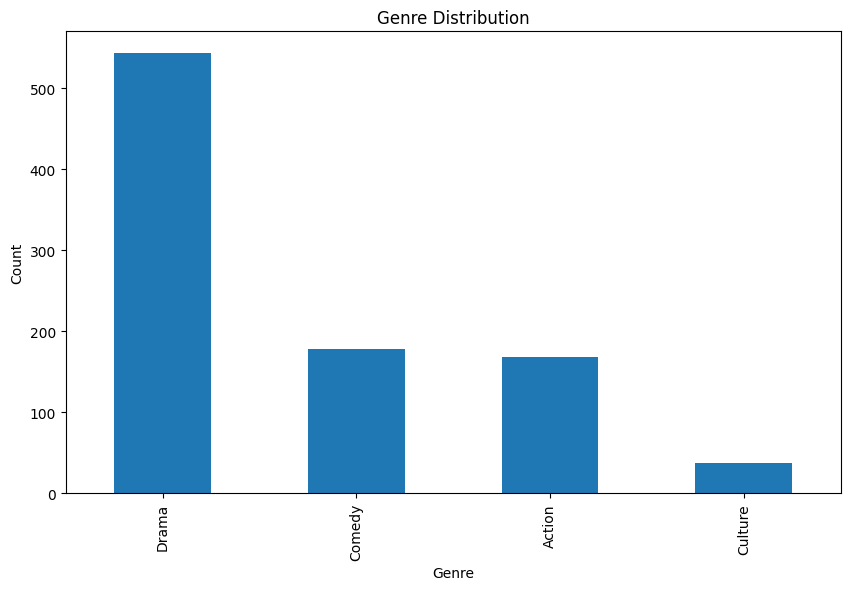

,Link,EN_title,PENGLISH_title,PERSIAN_title,Content_1,Content_2,Score,Year,Genre,Time,Preprocessed English,Preprocessed Persian,New_Genre
0,https://www.imvbox.com/watch-persian-movie-ira...,Local Anaesthetic,Bi Hessie Mozeie,بی‌حسی موضعی,جلال‌، دانشجوی سابق رشته فلسفه، متوجه می‌شود خ...,"Jalal, a dropouts philosophy student, realizes...",4.8,2018-01-01,Drama,73.0,jalal dropout philosophy student realize siste...,جلال دانشجوی سابق رشته فلسفه متوجه خواهرش اختل...,Drama
1,https://www.imvbox.com/watch-persian-movie-ira...,Disturbance,Ashoftegi,آشفته گی,«آشفته‌گی» رئالیستی و اجتماعی نیست. یک فیلم اس...,"After the murder of his rich twin brother, Bar...",3.8,2018-01-01,Crime,78.0,murder rich twin brother barbod assume identit...,آشفتهگی رئالیستی اجتماعی فیلم عشق جنایت,Action
2,https://www.imvbox.com/watch-persian-movie-ira...,Highlight,Haylayt,هایلایت,یک تصادف اتومبیل آدم‌هایی را در تقابل با هم قر...,A man and a woman are have a car accident and ...,4.4,2017-01-01,Drama,77.0,man woman car accident go coma spouse know two...,تصادف اتومبیل آدمهایی تقابل قرار مراقبت مصدومی...,Drama
3,https://www.imvbox.com/watch-persian-movie-ira...,Gilda,Geelda,گیلدا,گیلدا ماجرای زنی به نام «گیلدا» را روایت می کن...,Gilda who owns a restaurant has a terrible nig...,3.8,2018-01-01,Drama,79.0,gilda restaurant terrible night till morning s...,گیلدا ماجرای زنی نام گیلدا روایت صاحب رستوانیس...,Drama
4,https://www.imvbox.com/watch-persian-movie-ira...,Atmosphere Station,Istgahe Atmosfer,ایستگاه اتمسفر,این فیلم روایت گر داستان زندگی زوج جوانی به اس...,Vahid and Marjan are a young couple who have g...,5.6,2017-01-01,Drama,85.0,vahid marjan young couple get divorce month ag...,فیلم روایت‌گر داستان زندگی زوج جوانی اسم مرجان...,Drama


In [18]:
genre_counts = df['New_Genre'].value_counts()
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

display(df.head())

However, it is crucial to exercise caution when applying resampling methods. While these techniques can help balance the dataset, oversampling should not be excessive, as it may lead to model overfitting due to the model being exposed to repeated instances of the data. If you choose to train your model on an oversampled version of the dataset, ensure that your test dataset remains unaffected by the resampling process. It is recommended to split the data into an 80/20 ratio (train/test) before proceeding with resampling. (seed=42)



In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

class DataResampling:
    def __init__(self, df, target_col):
        self.df = df
        self.target_col = target_col

    def split_data(self, test_size=0.2, random_state=42):
        """
        Split the dataset into training and testing sets.

        Args:
            test_size (float): The proportion of the dataset to include in the test split (default: 0.2).
            random_state (int): The random seed for reproducibility (default: 42).

        Returns:
            tuple: (X_train, X_test, y_train, y_test)
                X_train (pandas.DataFrame): Training features.
                X_test (pandas.DataFrame): Testing features.
                y_train (pandas.Series): Training target.
                y_test (pandas.Series): Testing target.
        """
        X = self.df.drop(columns=[self.target_col])
        y = self.df[self.target_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test

    def resample_data(self, X_train, y_train, random_state=42):
        """
        Apply resampling techniques to balance the training dataset.

        Args:
            X_train (pandas.DataFrame): Training features.
            y_train (pandas.Series): Training target.
            random_state (int): The random seed for reproducibility (default: 42).

        Returns:
            tuple: (X_resampled, y_resampled)
                X_resampled (pandas.DataFrame): Resampled training features.
                y_resampled (pandas.Series): Resampled training target.
        """
        ros = RandomOverSampler(random_state=random_state)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
        X_resampled = pd.DataFrame(X_resampled, columns=X_train.columns)
        y_resampled = pd.Series(y_resampled, name=y_train.name)
        return X_resampled, y_resampled


target_col = 'New_Genre'
data_resampling = DataResampling(df, target_col)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = data_resampling.split_data()

# Resampling the training data to handle class imbalance
X_resampled, y_resampled = data_resampling.resample_data(X_train, y_train)


Additionally, encoding categorical variables is an essential step in feature engineering for machine learning models. Depending on the nature of your categorical features, you may need to apply techniques such as one-hot encoding or label encoding to convert them into a format suitable for model training.

In [20]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

class CategoricalEncoder:
    def __init__(self, df, categorical_cols):
        self.df = df
        self.categorical_cols = categorical_cols

    def label_encode(self, drop_first=False):
        """
        Apply label encoding to categorical variables.

        Args:
            drop_first (bool): If True, drop the first column of one-hot encoded data to avoid multicollinearity.

        Returns:
            pandas.DataFrame: The DataFrame with categorical variables encoded.
        """
        df_encoded = self.df.copy()
        label_encoder = LabelEncoder()

        for col in self.categorical_cols:
            df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

        return df_encoded

    def one_hot_encode(self, drop_first=False):
        """
        Apply one-hot encoding to categorical variables.

        Args:
            drop_first (bool): If True, drop the first column of one-hot encoded data to avoid multicollinearity.

        Returns:
            pandas.DataFrame: The DataFrame with categorical variables one-hot encoded.
        """
        df_encoded = pd.get_dummies(self.df, columns=self.categorical_cols, drop_first=drop_first)
        return df_encoded


categorical_encoder = CategoricalEncoder(df, categorical_cols)
# Applying label encoding
df_label_encoded = categorical_encoder.label_encode()
# Applying one-hot encoding
df_one_hot_encoded = categorical_encoder.one_hot_encode(drop_first=True)


# **Fine-tuning**

In [ ]:
################################################################################################
################################################################################################
s = "we use low epochs to be able to run the cells"
print(s)

In [21]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

## Persian

In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_resampled)
y_test_encoded = label_encoder.transform(y_test)

X_train_texts = X_resampled['Preprocessed Persian'].tolist()
X_test_texts = X_test['Preprocessed Persian'].tolist()

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-zwnj-base")
model = AutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-fa-zwnj-base", num_labels=4)

model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/426k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/473M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Preprocessed

In [24]:
train_encodings = tokenizer(X_train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test_texts, truncation=True, padding=True, max_length=512)
train_dataset = CustomDataset(train_encodings, y_train_encoded)
test_dataset = CustomDataset(test_encodings, y_test_encoded)

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

num_epochs = 5
batch_size = 32

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(output_dir="tmp", num_train_epochs=num_epochs, per_device_train_batch_size=batch_size, warmup_steps=500, weight_decay=0.01, logging_steps=10, evaluation_strategy="epoch", save_strategy="epoch", greater_is_better=True, load_best_model_at_end=True, metric_for_best_model="accuracy")

trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset, compute_metrics=compute_metrics)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.357000,1.348957,0.317204,0.348513,0.402037,0.317204
2,1.029100,1.267708,0.403226,0.400506,0.468037,0.403226
3,0.604300,1.151983,0.494624,0.473905,0.462444,0.494624
4,0.289700,1.306203,0.483871,0.473379,0.467523,0.483871
5,0.098800,1.637823,0.500000,0.451392,0.425275,0.500000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=275, training_loss=0.7478799913146279, metrics={'train_runtime': 770.8434, 'train_samples_per_second': 11.286, 'train_steps_per_second': 0.357, 'total_flos': 1935905185936800.0, 'train_loss': 0.7478799913146279, 'epoch': 5.0})

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


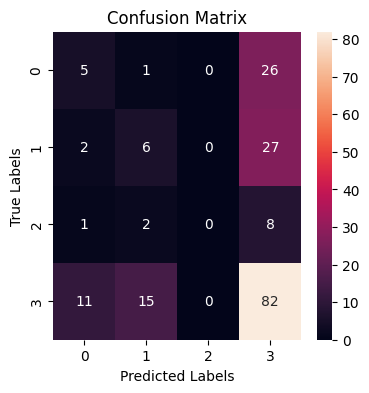

In [26]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
def display_confusion_matrix(confusion_mat):
    plt.figure(figsize=(4 , 4))
    sns.heatmap(confusion_mat , annot=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

model_predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(model_predictions.predictions , axis=1)

confusion_mat = confusion_matrix(y_test_encoded , predicted_labels)
accuracy = accuracy_score(y_test_encoded , predicted_labels)
weighted_f1 = f1_score(y_test_encoded , predicted_labels , average='weighted')

display_confusion_matrix(confusion_mat)

### Not Preprocessed


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.341200,1.317430,0.419355,0.430519,0.450571,0.419355
2,1.018200,1.202823,0.462366,0.454202,0.506481,0.462366
3,0.567600,1.115951,0.537634,0.485122,0.465010,0.537634
4,0.223900,1.386647,0.548387,0.511030,0.495076,0.548387
5,0.171400,1.706675,0.553763,0.485956,0.470322,0.553763


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


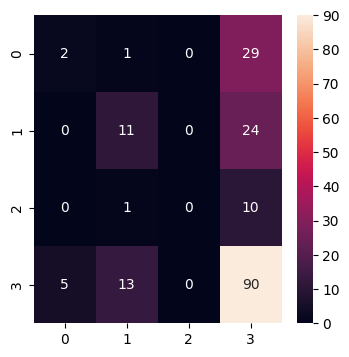

In [27]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-zwnj-base")
classification_model = AutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-fa-zwnj-base" , num_labels = 4)
#classification_model.to(device)


train_texts = X_resampled['Content_1'].tolist()
test_texts = X_test['Content_1'].tolist()

train_encodings = tokenizer(train_texts , truncation = True , padding = True , max_length = 512)
test_encodings = tokenizer(test_texts , truncation = True , padding = True , max_length = 512)

train_dataset = CustomDataset(train_encodings , y_train_encoded)
test_dataset = CustomDataset(test_encodings , y_test_encoded)


training_args = TrainingArguments(output_dir = "tmp" , num_train_epochs = 5 , per_device_train_batch_size = 32 , warmup_steps = 500 , weight_decay = 0.01 , logging_steps = 10 , evaluation_strategy = "epoch" , save_strategy = "epoch" , greater_is_better = True , load_best_model_at_end = True , metric_for_best_model = "accuracy")

trainer = Trainer(model = classification_model , args = training_args , train_dataset = train_dataset , eval_dataset = test_dataset , compute_metrics = compute_metrics)

trainer.train()

model_predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(model_predictions.predictions , axis = 1)

confusion_mat = confusion_matrix(y_test_encoded , predicted_labels)
accuracy = accuracy_score(y_test_encoded , predicted_labels)
weighted_f1 = f1_score(y_test_encoded , predicted_labels , average = 'weighted')

plt.figure(figsize = (4 , 4))
sns.heatmap(confusion_mat , annot = True)
plt.show()

## English


In [28]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Preprocessed

In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder

# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_resampled)
y_test_encoded = label_encoder.transform(y_test)


X_train_texts = X_resampled['Preprocessed English'].tolist()
X_test_texts = X_test['Preprocessed English'].tolist()
train_encodings = tokenizer(X_train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test_texts, truncation=True, padding=True, max_length=512)


train_dataset = CustomDataset(train_encodings, y_train_encoded)
test_dataset = CustomDataset(test_encodings, y_test_encoded)


num_epochs = 5
batch_size = 32

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}


training_args = TrainingArguments(output_dir="tmp", num_train_epochs=num_epochs, per_device_train_batch_size=batch_size, warmup_steps=500, weight_decay=0.01, logging_steps=10, evaluation_strategy="epoch", save_strategy="epoch", greater_is_better=True, load_best_model_at_end=True, metric_for_best_model="accuracy")


trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset, compute_metrics=compute_metrics)
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.365400,1.390816,0.204301,0.140970,0.429889,0.204301
2,1.099900,1.270362,0.295699,0.265349,0.538910,0.295699
3,0.757400,1.182723,0.381720,0.391481,0.533799,0.381720
4,0.460900,1.289916,0.462366,0.480171,0.602716,0.462366
5,0.223900,1.198016,0.634409,0.589684,0.656834,0.634409


TrainOutput(global_step=275, training_loss=0.8479877714677291, metrics={'train_runtime': 583.6481, 'train_samples_per_second': 14.906, 'train_steps_per_second': 0.471, 'total_flos': 1645295862412800.0, 'train_loss': 0.8479877714677291, 'epoch': 5.0})

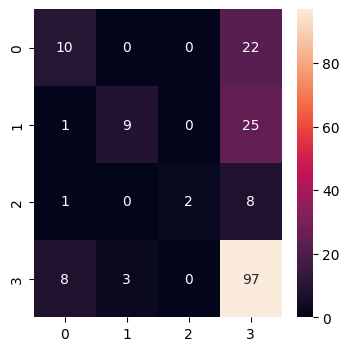

In [32]:
# Predictions using the trained model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
trainer_predictions = trainer.predict(test_dataset)
trainer_predicted_labels = np.argmax(trainer_predictions.predictions, axis=1)

# Confusion matrix calculation
confusion_matrix = confusion_matrix(y_test_encoded, trainer_predicted_labels)

# Accuracy and weighted F1 score calculation
accuracy = accuracy_score(y_test_encoded, trainer_predicted_labels)
f1_weighted_score = f1_score(y_test_encoded, trainer_predicted_labels, average='weighted')

plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix, annot=True)
plt.show()


### Not Preprocessed


In [35]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Encode target variables
encoded_train_labels = encoder.fit_transform(y_resampled)
encoded_test_labels = encoder.transform(y_test)

train_texts = X_resampled['Content_2'].tolist()
test_texts = X_test['Content_2'].tolist()


tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)
model.to(device)
print(f"Model device: {next(model.parameters()).device}")

# Create datasets for training and evaluation
train_dataset = CustomDataset(train_encodings, encoded_train_labels)
eval_dataset = CustomDataset(test_encodings, encoded_test_labels)


num_epochs = 5
batch_size = 32


def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(pred.label_ids, preds, average='weighted')
    acc = accuracy_score(pred.label_ids, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Trainer configuration
training_args = TrainingArguments(output_dir="tmp", num_train_epochs=num_epochs, per_device_train_batch_size=batch_size, warmup_steps=500, weight_decay=0.01, logging_steps=10, evaluation_strategy="epoch", save_strategy="epoch", greater_is_better=True, load_best_model_at_end=True, metric_for_best_model="accuracy")
trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset, compute_metrics=compute_metrics)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model device: cuda:0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.350600,1.323589,0.462366,0.471963,0.485768,0.462366
2,1.137000,1.366915,0.456989,0.469889,0.562823,0.456989
3,0.708100,1.088486,0.569892,0.583981,0.613385,0.569892
4,0.362800,1.090750,0.537634,0.538214,0.548277,0.537634
5,0.216700,1.271908,0.537634,0.511152,0.547314,0.537634


TrainOutput(global_step=275, training_loss=0.8305251474813982, metrics={'train_runtime': 888.6123, 'train_samples_per_second': 9.791, 'train_steps_per_second': 0.309, 'total_flos': 2289107286835200.0, 'train_loss': 0.8305251474813982, 'epoch': 5.0})

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


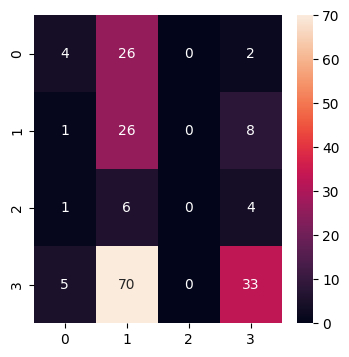

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from transformers import Trainer

# Assuming `trainer` and `test_dataset` are defined elsewhere in your code

# Predict using the trained model
model_predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(model_predictions.predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, predicted_labels)

# Calculate accuracy and weighted F1 score
accuracy = accuracy_score(y_test_encoded, predicted_labels)
f1_weighted = f1_score(y_test_encoded, predicted_labels, average='weighted')



# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True)
plt.show()

# Results Analysis

Analyze the results of the Fine-tuning section.


In the fine-tuning phase of model development, the results are pivotal in determining the optimal hyperparameters for achieving the best performance. By  varying hyperparameters and evaluating metrics such as accuracy, precision, recall, we will gain insights. We visualize a train model in this notebook, set approptiate hyperparameters and use them to show our loss and differenc to the actual values, we get that for example after 5 epochs, the accuracy is more than 50 percent although at last the result of the unprocessed was not good!. Visualizing learning curves helps in understanding the model's convergence and detecting signs of underfitting or overfitting. Ultimately, the goal is to select the hyperparameter configuration that not only maximizes performance metrics but also balances computational efficiency and generalizability to new data. Thanks for reading.